# **TASK TEST:** 
There are 30 satellite pictures of houses and 25 corresponding labels that indicate the roofs:
1- Take those 25 data points and train a neural network on them 
2- You should be able to explain what you are doing - in terms of code as well as in terms of why certain steps are good choices. 
3- Evaluate your network on the 5 remaining test images by making predictions of the roofs

## **Data Description**: There are two sets of data:
#####     • 30 satellite images of houses.
#####     • 25 corresponding labels that indicate where the roofs are located in these images.
#### These labels are typically binary masks where the roof areas are marked.

## **Freedom in Architecture:**
#### I have the complete freedom to design the architecture of the neural network i.e I can choose any neural network architecture I think is suitable for the task. I can can also use any predefined network architecture available in popular deep learning frameworks like TensorFlow or PyTorch.

## **Objective**:
#### The goal is to train a neural network to learn and predict the locations of roofs within these satellite images. Essentially, we want to build a model that can segment or identify the roof regions within each image.

In [101]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### **In section 1:** We import various Python libraries and modules necessary for the tasks ahead. It includes libraries for data visualization (matplotlib), working with files and paths (os), image processing (cv2), numerical computations (numpy), deep learning (tensorflow), and machine learning utilities (sklearn).

In [132]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.models import Model

In [133]:
# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [134]:
# Define paths to image and label folders
IMAGE_FOLDER = '/content/drive/MyDrive/dida_test_task/images/'
LABEL_FOLDER = '/content/drive/MyDrive/dida_test_task/labels/'

# Constants for data preprocessing
IMAGE_SIZE = (256, 256)
NUM_CHANNELS = 3

#### **Section 2:** This function preprocess_data takes the paths to image and label folders as input and performs the following steps:
* ####    Loads image and label file paths.
* ####    Reads image and label files using OpenCV (cv2).
* ####    Resizes both images and labels to a common size specified by IMAGE_SIZE.
* ####    Normalizes pixel values of images and labels to the range [0, 1].


In [135]:
# Function to preprocess image and label data
def preprocess_data(image_folder, label_folder):
    # Load and preprocess the data
    image_paths = sorted([os.path.join(image_folder, filename) for filename in os.listdir(image_folder)])
    label_paths = sorted([os.path.join(label_folder, filename) for filename in os.listdir(label_folder)])

    images = [cv2.imread(img_path) for img_path in image_paths]
    labels = [cv2.imread(label_path, cv2.IMREAD_GRAYSCALE) for label_path in label_paths]

    # Resize images and labels to a common size
    images = [cv2.resize(img, IMAGE_SIZE) for img in images]
    labels = [cv2.resize(label, IMAGE_SIZE) for label in labels]

    # Normalize pixel values to the range [0, 1]
    images = [img / 255.0 for img in images]
    labels = [label / 255.0 for label in labels]

    return np.array(images), np.array(labels)

#### **In sections 3:** function build_unet_model defines the architecture of a U-Net model using the Keras functional API. It is a popular choice for tasks like image segmentation, since its design with skip connections helps preserve fine details and spatial information, making it effective for tasks like roof segmentation, where the precise localization of boundaries is important.
#### It takes input_size as an argument (defaulting to the specified size) and creates a U-Net model with an encoder-decoder structure, including convolutional, pooling, and upsampling layers, and an output layer with a sigmoid activation function.


In [136]:
# building the u-net model

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout

def build_unet_model(input_height, input_width, input_channels):
    """
    Creates a U-Net model for image segmentation.

    Args:
        input_height (int): Height of the input images.
        input_width (int): Width of the input images.
        input_channels (int): Number of channels in the input images.

    Returns:
        keras.models.Model: The U-Net model.
    """
    # Input layer
    inputs = Input((input_height, input_width, input_channels))

    # Contracting path (encoding)
    conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    conv1 = Dropout(0.1)(conv1)
    conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    # Repeat similar blocks for other layers (conv2, conv3, conv4, conv5)
    conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = Dropout(0.1)(conv2)
    conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    conv5 = Dropout(0.3)(conv5)
    conv5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)

    # Expansive path (decoding)
    # Upsampling and concatenation with skip connections
    up6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up6)
    conv6 = Dropout(0.2)(conv6)
    conv6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

    # Repeat similar blocks for other upsampling layers (up7, up8, up9)
    up7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up7)
    conv7 = Dropout(0.2)(conv7)
    conv7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)

    up8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up8)
    conv8 = Dropout(0.1)(conv8)
    conv8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)

    up9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up9)
    conv9 = Dropout(0.1)(conv9)
    conv9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)

    # Output layer with sigmoid activation
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model


### **Section 4:** This is the main part of the code, which mactches the entire process. Here's details of what it does:
### **Step 1: Data Preprocessing**
#### *     Calls the preprocess_data function to load and preprocess image and label data from the specified folders.
#### *     Splits the data into training and testing sets, using 20% of data for testing.

### **Step 2: Define and Compile the Model**
#### *     Calls the build_unet_model function to define the U-Net model.
#### *     Compiles the model with the Adam optimizer, binary cross-entropy loss function, and accuracy metric.
### **Step 3: Model Training**
#### *     Trains the model using the training data for the specified number of epochs and batch size.
#### *     Uses 20% of the training data for validation during training.
#### *     Saves the trained model as 'best_model.h5' for future use in making predictions on unseen images.
### **Step 4: Model Evaluation and Visualization**
#### *     Evaluates the trained model on the test data and prints the test loss and accuracy.
#### *     Makes predictions on the test data.
#### *     Saves the predicted masks as images (e.g., 'predicted_mask_0.png', 'predicted_mask_1.png', etc.).
#### *     Visualizes some predictions by displaying the images and predicted images for up to 5 test samples.

In [137]:
# Preprocess the data
X, y = preprocess_data(IMAGE_FOLDER, LABEL_FOLDER)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X[:25], y[:25], test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [138]:
# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Define a learning rate schedule
def lr_schedule(epoch):
    if epoch < 100:
        return 0.001
    elif epoch < 150:
        return 0.0001
    else:
        return 0.00001

# Create a learning rate scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

# Constants for model training
EPOCHS = 200
BATCH_SIZE = 32    # Choose an initial batch size (e.g., 32)
VALIDATION_SPLIT = 0.2
learning_rate = 0.001

# Define and Compile the Model
model = build_unet_model(256,256,3)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train the model with the learning rate scheduler
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), callbacks=[early_stopping, checkpoint, lr_scheduler])


Epoch 1/200
1/1 [==============================] - 13s 13s/step - loss: 0.8058 - accuracy: 0.1385 - val_loss: 0.7276 - val_accuracy: 0.2019 - lr: 0.0010
Epoch 2/200


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 8s 8s/step - loss: 0.7388 - accuracy: 0.2167 - val_loss: 0.6934 - val_accuracy: 0.5520 - lr: 0.0010
Epoch 3/200
1/1 [==============================] - 7s 7s/step - loss: 0.7017 - accuracy: 0.4388 - val_loss: 0.6714 - val_accuracy: 0.7661 - lr: 0.0010
Epoch 4/200
1/1 [==============================] - 8s 8s/step - loss: 0.6758 - accuracy: 0.6497 - val_loss: 0.6386 - val_accuracy: 0.8196 - lr: 0.0010
Epoch 5/200
1/1 [==============================] - 7s 7s/step - loss: 0.6108 - accuracy: 0.7759 - val_loss: 0.5216 - val_accuracy: 0.8254 - lr: 0.0010
Epoch 6/200
1/1 [==============================] - 7s 7s/step - loss: 0.5608 - accuracy: 0.8149 - val_loss: 0.5668 - val_accuracy: 0.8269 - lr: 0.0010
Epoch 7/200
1/1 [==============================] - 8s 8s/step - loss: 0.5174 - accuracy: 0.8258 - val_loss: 0.5696 - val_accuracy: 0.8272 - lr: 0.0010
Epoch 8/200
1/1 [==============================] - 7s 7s/step - loss: 0.5216 - accuracy: 0.8290 - val_loss

In [139]:
# Model Evaluation and Visualization
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Make predictions on test data
predicted_images = model.predict(X_test)
# Save predicted masks as images
for i, predicted_image in enumerate(predicted_images):
    cv2.imwrite(f'predicted_image_{i}.png', (predicted_image * 255).astype(np.uint8))

1/1 [==============================] - 0s 449ms/step - loss: 0.3127 - accuracy: 0.8418
Test Loss: 0.3126879334449768
Test Accuracy: 0.841766357421875
1/1 [==============================] - 1s 645ms/step


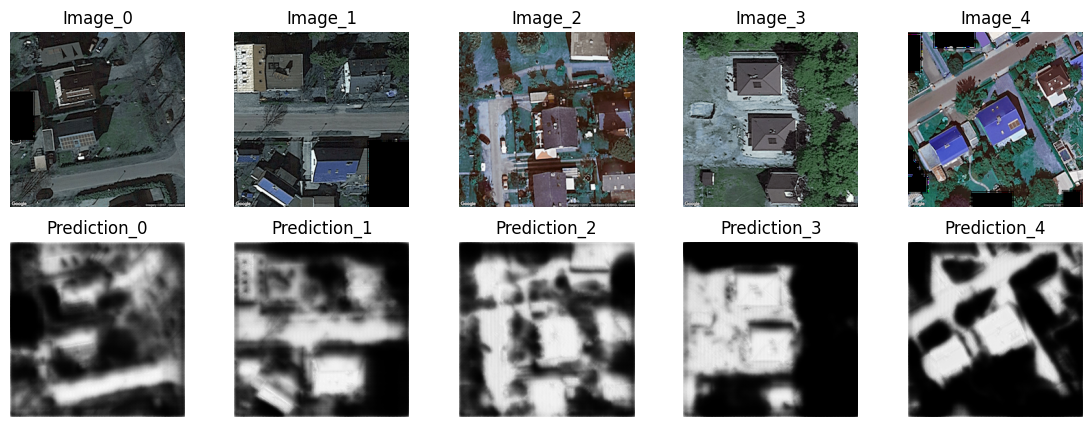

In [140]:
# Visualize the predictions and ground truth
%matplotlib inline
plt.figure(figsize=(14, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[i])
    plt.title(f'Image_{i}')
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(predicted_images[i].squeeze(), cmap='gray')
    plt.title(f'Prediction_{i}')
    plt.axis('off')

plt.savefig('data_predictions.png')
plt.show()

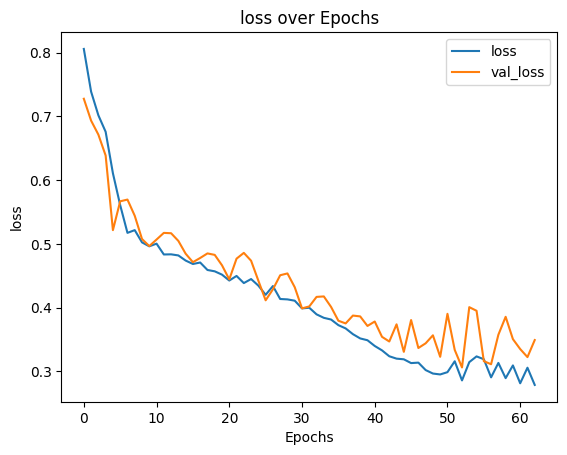

In [145]:
# Function to plot loss and accuracy history
def plot_segm_history(history, metrics=[], losses=[]):
    # Create a single figure
    fig, ax = plt.subplots()

    # Plot metrics
    # for metric in metrics:
    #     ax.plot(history.history[metric], label=metric)
    #     ax.set_xlabel('Epochs')
    #     ax.set_ylabel(metric)
    #     ax.set_title(f'{metric} over Epochs')

    # Plot losses
    for loss in losses:
        ax.plot(history.history[loss], label=loss)
        ax.set_xlabel('Epochs')
        ax.set_ylabel(loss)
        ax.set_title(f'{loss} over Epochs')

    # Add 'val_' version of metrics and losses
    # for metric in metrics:
    #     val_metric = 'val_' + metric
    #     if val_metric in history.history:
    #         ax.plot(history.history[val_metric], label=val_metric)
    for loss in losses:
        val_loss = 'val_' + loss
        if val_loss in history.history:
            ax.plot(history.history[val_loss], label=val_loss)

    # Add a legend for all lines
    ax.legend()

    # Show the figure
    plt.savefig('loss_result.png')
    plt.show()

# Call the modified function to plot loss and accuracy history
plot_segm_history(
    history,  metrics=['accuracy'], losses=['loss'])


In [146]:
# Load the saved model and perform inference on unseen data
loaded_model = load_model('best_model.h5')
unseen_data = X[25:]
unseen_data_predictions = loaded_model.predict(unseen_data)
predicted_classes = unseen_data_predictions.argmax(axis=1)
predicted_classes = predicted_classes.flatten()  # Flatten the array to make it 1-dimensional

# Calculate class counts
class_counts = np.bincount(predicted_classes)

1/1 [==============================] - 1s 1s/step


In [147]:
# Save predicted masks as images for unseen data
for i, predicted_img in enumerate(unseen_data_predictions):
    cv2.imwrite(f'predicted_unseen_image_{i}.png', (predicted_img * 255).astype(np.uint8))

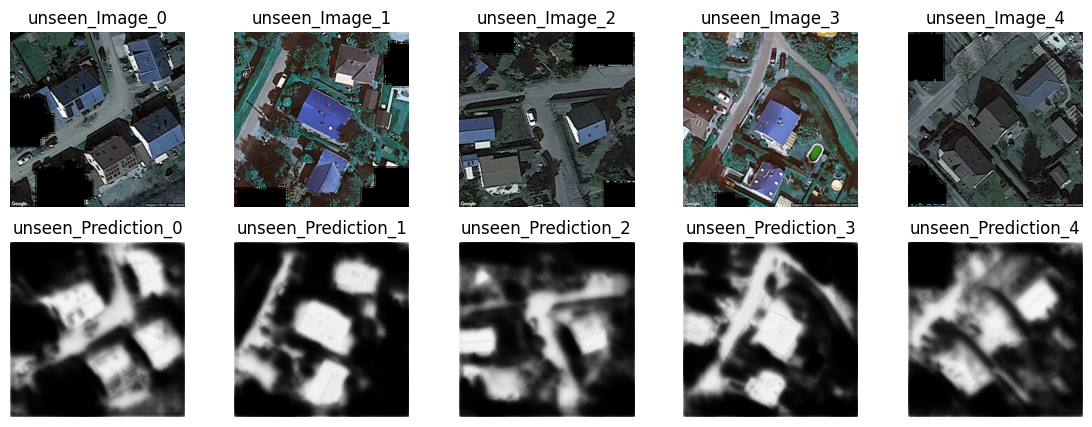

In [148]:
# Visualize predictions for unseen data
plt.figure(figsize=(14, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(unseen_data[i])
    plt.title(f'unseen_Image_{i}')
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(unseen_data_predictions[i].squeeze(), cmap='gray')
    plt.title(f'unseen_Prediction_{i}')
    plt.axis('off')

plt.savefig('unseen_data_predictions.png')
plt.show()


#**Analyzing and discussing the results:**

## **Loss:**

1. The loss value measures how well the model is performing during training. A lower loss indicates better model performance. In our case, the loss values decrease as the number of epochs increases, which suggests that the model is gradually improving its performance.
2. The training loss starts at 0.7388 and decreases consistently over the epochs, reaching 0.2789 at epoch 63.
3. The validation loss starts at 0.6934 and also decreases steadily, reaching 0.3493 at epoch 63.
4. These decreasing loss values indicate that the model is learning to make more accurate predictions as the training progresses.

## **Accuracy:**

1. The accuracy value measures the percentage of correctly predicted samples in the dataset. A higher accuracy indicates better model performance. In our case, the accuracy values increase as the number of epochs increases, indicating that the model is learning to make more accurate predictions.

2. The training accuracy starts at 0.2167 and increases consistently over the epochs, reaching 0.8341 at epoch 63.
3. The validation accuracy starts at 0.5520, and it also increases steadily, reaching 0.8297 at epoch 63.
4. These increasing accuracy values suggest that the model is becoming more proficient at predicting the correct class labels for the given data.
Learning Rate:

## **Discussion:**

*   Based on the results, it's evident that both the loss and accuracy values improve as the number of epochs increases. The model starts with relatively high loss and low accuracy but gradually improves its performance over time. This indicates that the model is learning to better understand the input data and make more accurate predictions.

*   The validation loss and accuracy follow a similar trend to the training metrics, which suggests that the model is not overfitting to the training data. Overfitting occurs when the model performs well on the training data but fails to generalize to new, unseen data. In our case, the increasing validation metrics indicate that the model is generalizing well to unseen data.